In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV


## Data exploration

### Initial exploration

In [2]:
df=pd.read_csv('GUIDE_Train.csv',nrows=100000)

In [3]:
df.shape

(100000, 45)

In [4]:
df.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [5]:
df.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City'],
      dtype='object')

In [6]:
df.isna().sum()

Id                        0
OrgId                     0
IncidentId                0
AlertId                   0
Timestamp                 0
DetectorId                0
AlertTitle                0
Category                  0
MitreTechniques       57496
IncidentGrade           525
ActionGrouped         99412
ActionGranular        99412
EntityType                0
EvidenceRole              0
DeviceId                  0
Sha256                    0
IpAddress                 0
Url                       0
AccountSid                0
AccountUpn                0
AccountObjectId           0
AccountName               0
DeviceName                0
NetworkMessageId          0
EmailClusterId        98984
RegistryKey               0
RegistryValueName         0
RegistryValueData         0
ApplicationId             0
ApplicationName           0
OAuthApplicationId        0
ThreatFamily          99200
FileName                  0
FolderPath                0
ResourceIdName            0
ResourceType        

In [7]:
cat=df.select_dtypes(include='object')
for i in cat:
    print(cat[i].unique())

['2024-06-04T06:05:15.000Z' '2024-06-14T03:01:25.000Z'
 '2024-06-13T04:52:55.000Z' ... '2024-06-15T09:32:31.000Z'
 '2024-06-04T01:37:44.000Z' '2024-06-15T21:32:05.000Z']
['InitialAccess' 'Exfiltration' 'CommandAndControl' 'Execution'
 'SuspiciousActivity' 'Impact' 'Collection' 'CredentialAccess'
 'Persistence' 'Discovery' 'Malware' 'DefenseEvasion' 'Exploit'
 'PrivilegeEscalation' 'LateralMovement' 'Ransomware' 'UnwantedSoftware'
 'CredentialStealing']
[nan 'T1189' 'T1078;T1078.004' 'T1566' 'T1098;T1114'
 'T1559;T1106;T1059.005' 'T1566.002' 'T1133' 'T1110;T1078' 'T1071;T1048'
 'T1566.001' 'T1595;T1046' 'T1059.003' 'T1110;T1110.003;T1110.001'
 'T1003;T1098' 'T1030' 'T1098' 'T1046;T1071;T1210' 'T1078;T1098' 'T1190'
 'T1111;T1557' 'T1568;T1573;T1008' 'T1497.002'
 'T1047;T1059;T1053;T1569;T1059.001;T1053.002;T1053.005;T1569.002' 'T1041'
 'T1548;T1574.002' 'T1078' 'T1110'
 'T1055;T1055.001;T1055.002;T1055.003;T1055.004;T1055.012;T1059.001'
 'T1528' 'T1559;T0871;T0853;T0823;T0863' 'T1046;T10

### EDA

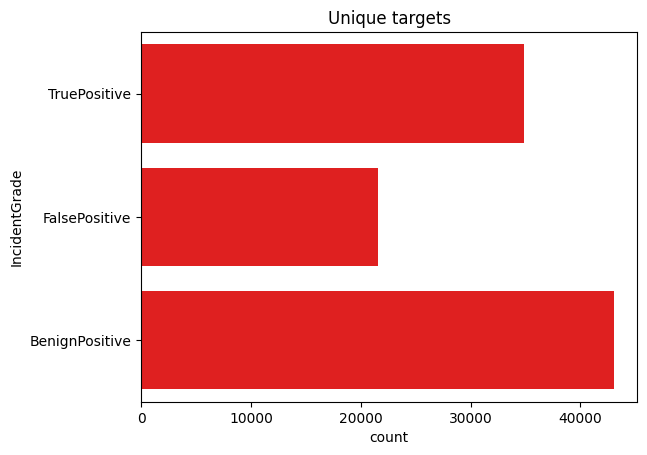

In [8]:
sns.countplot(df['IncidentGrade'],color='red')
plt.title('Unique targets')
plt.show()

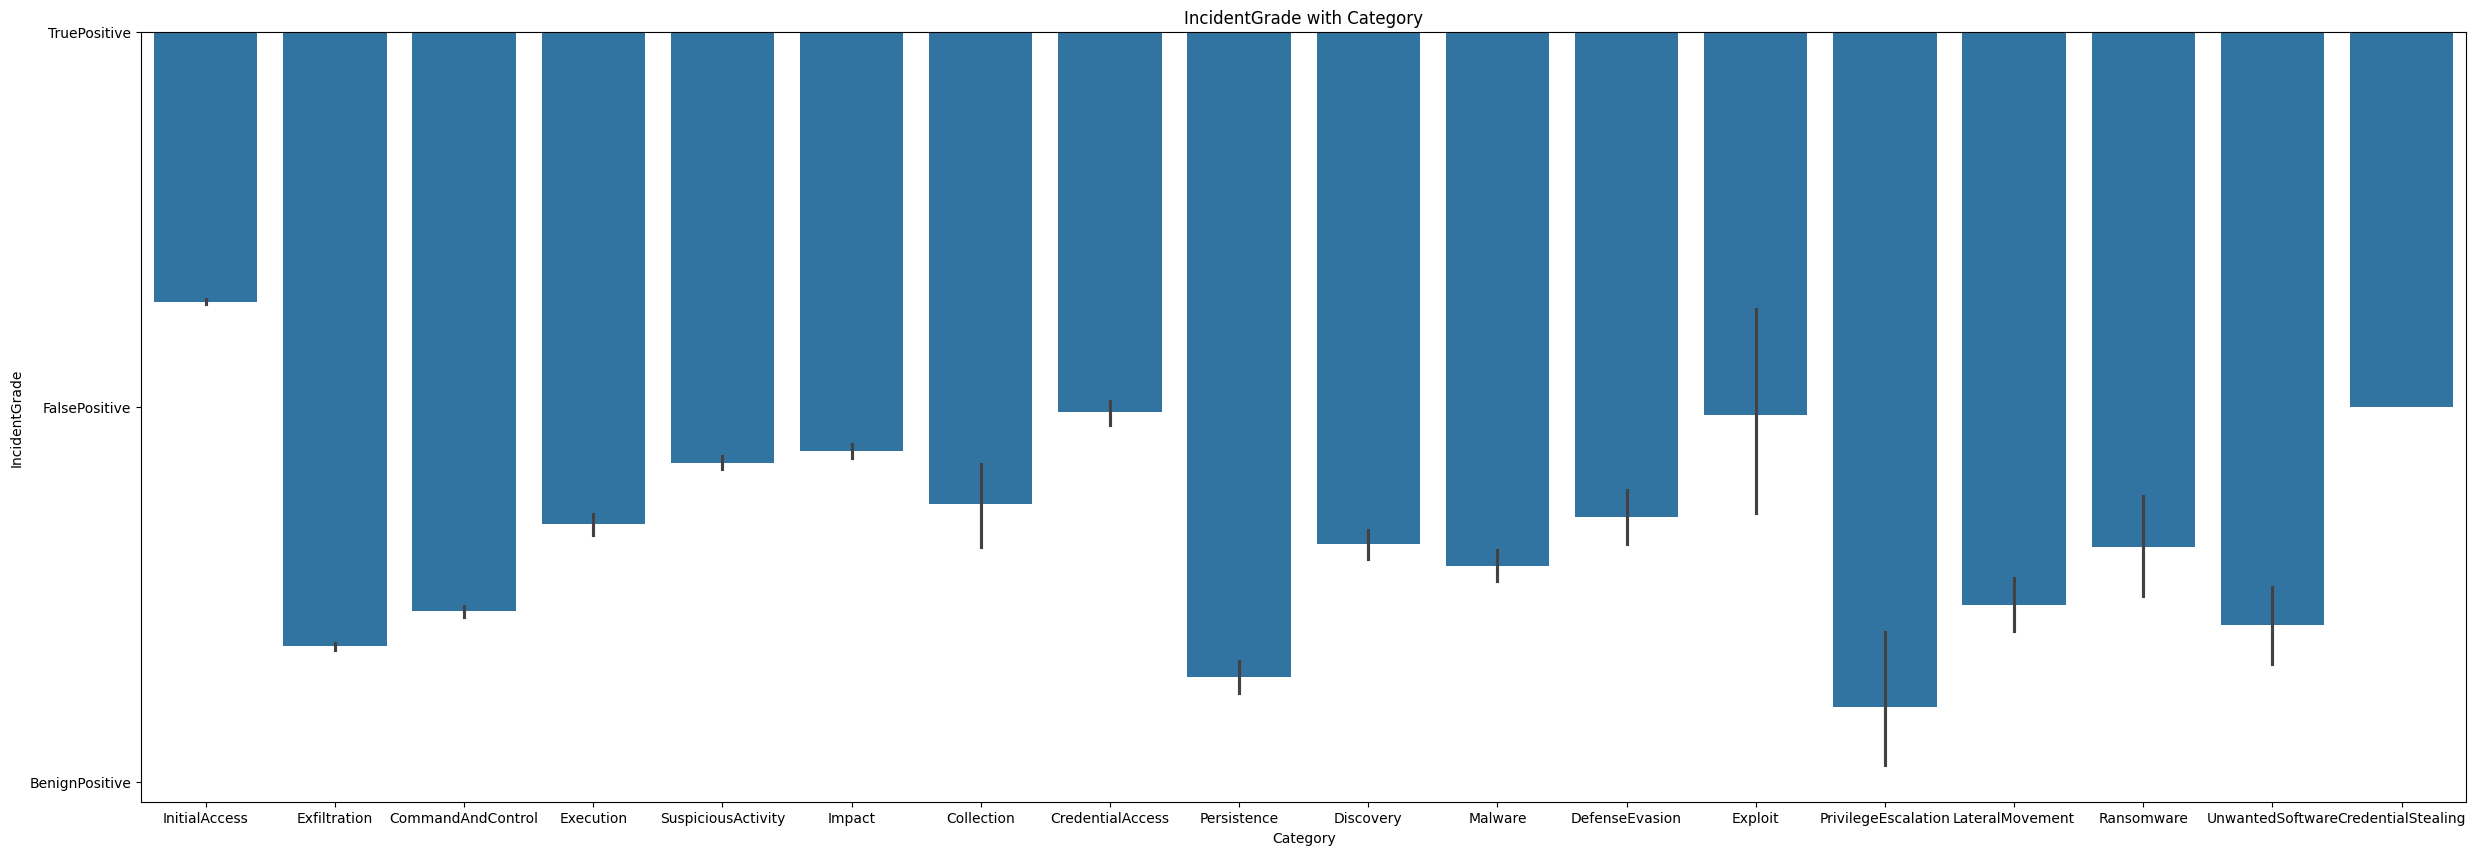

In [9]:
plt.figure(figsize=(30,10))
plt.title('IncidentGrade with Category')
sns.barplot(x=df['Category'],y=df['IncidentGrade'])
plt.show()

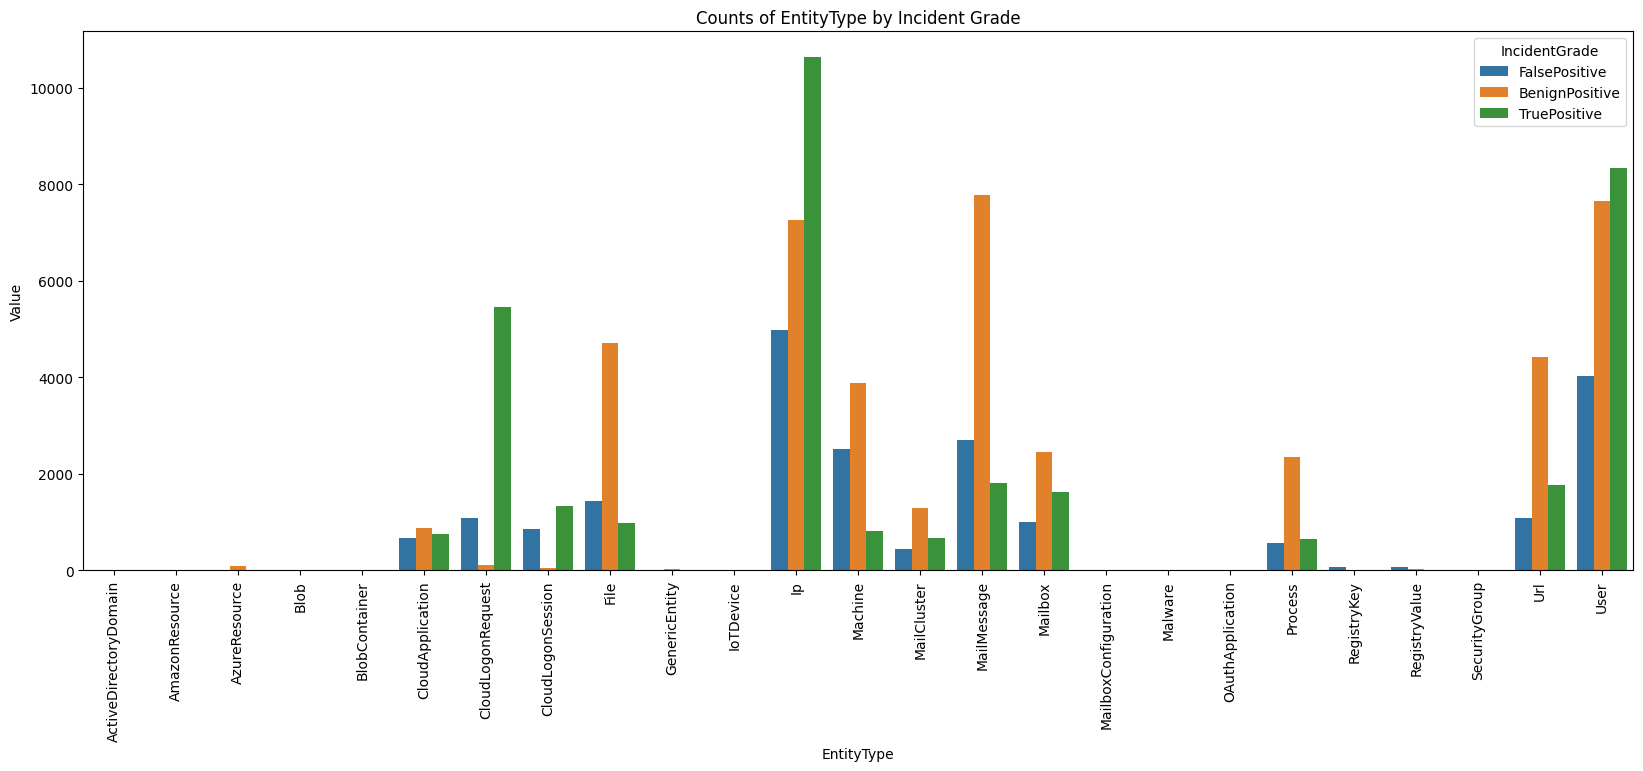

In [10]:
grouped_data=df.groupby(["EntityType","IncidentGrade"]).size().reset_index(name="Value")

plt.figure(figsize=(20,7))
sns.barplot(data=grouped_data,x="EntityType", y="Value", hue = "IncidentGrade")
plt.xticks(rotation=90)
plt.title("Counts of EntityType by Incident Grade")
plt.show()

In [11]:
grouped_data

,EntityType,IncidentGrade,Value
0,ActiveDirectoryDomain,FalsePositive,1
1,AmazonResource,BenignPositive,1
2,AzureResource,BenignPositive,85
3,AzureResource,FalsePositive,5
4,AzureResource,TruePositive,15
...,...,...,...
58,Url,FalsePositive,1096
59,Url,TruePositive,1771
60,User,BenignPositive,7661
61,User,FalsePositive,4019


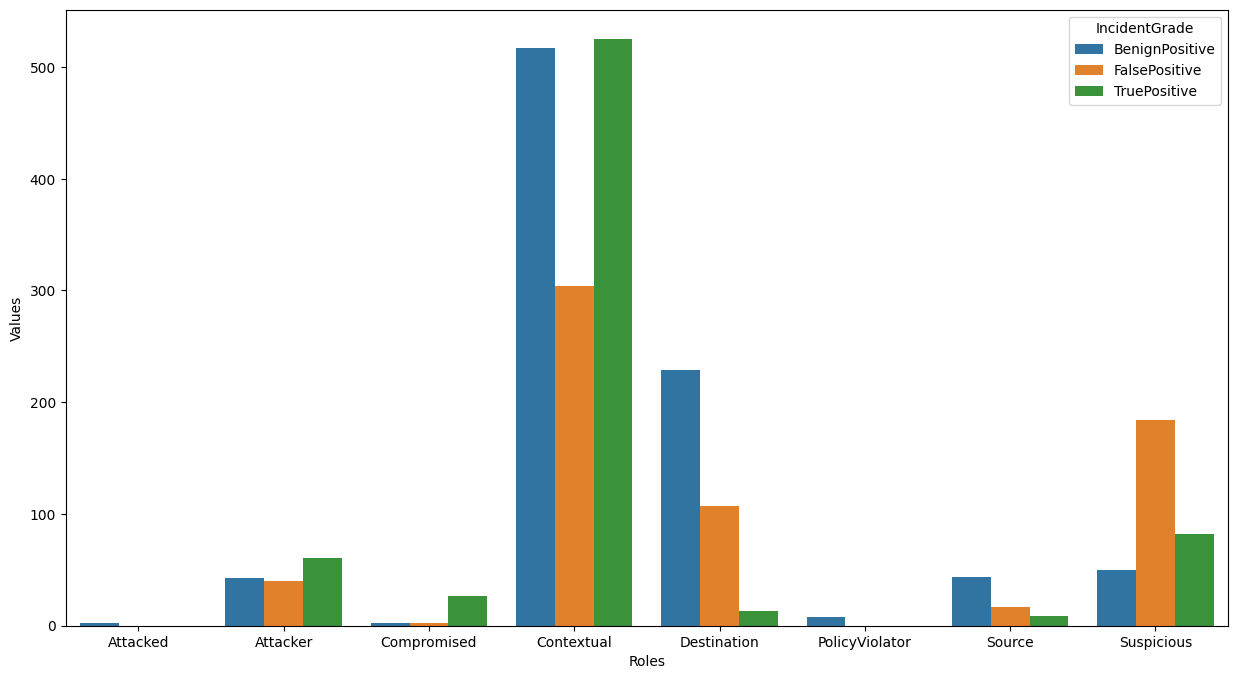

In [12]:
grouped_data_2=df.groupby(["Roles","IncidentGrade"]).size().reset_index(name="Values")
plt.figure(figsize=(15,8))
sns.barplot(data=grouped_data_2,x='Roles',y='Values',hue='IncidentGrade')
plt.show()

In [13]:
grouped_data_2

,Roles,IncidentGrade,Values
0,Attacked,BenignPositive,2
1,Attacker,BenignPositive,43
2,Attacker,FalsePositive,40
3,Attacker,TruePositive,61
4,Compromised,BenignPositive,2
5,Compromised,FalsePositive,2
6,Compromised,TruePositive,27
7,Contextual,BenignPositive,517
8,Contextual,FalsePositive,304
9,Contextual,TruePositive,525


## Handeling missing values

In [14]:
df.isna().sum()

Id                        0
OrgId                     0
IncidentId                0
AlertId                   0
Timestamp                 0
DetectorId                0
AlertTitle                0
Category                  0
MitreTechniques       57496
IncidentGrade           525
ActionGrouped         99412
ActionGranular        99412
EntityType                0
EvidenceRole              0
DeviceId                  0
Sha256                    0
IpAddress                 0
Url                       0
AccountSid                0
AccountUpn                0
AccountObjectId           0
AccountName               0
DeviceName                0
NetworkMessageId          0
EmailClusterId        98984
RegistryKey               0
RegistryValueName         0
RegistryValueData         0
ApplicationId             0
ApplicationName           0
OAuthApplicationId        0
ThreatFamily          99200
FileName                  0
FolderPath                0
ResourceIdName            0
ResourceType        

In [15]:
df.drop(columns=['Id','ActionGrouped','ActionGranular','EmailClusterId','LastVerdict','SuspicionLevel','AntispamDirection','ThreatFamily','ResourceType','Roles','MitreTechniques'],inplace=True,axis=1)

In [16]:
df.head()

,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
0,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,TruePositive,Ip,Related,...,3421,881,289573,117668,3586,5,66,31,6,3
1,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,FalsePositive,User,Impacted,...,3421,881,289573,117668,3586,5,66,242,1445,10630
2,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,FalsePositive,Url,Related,...,3421,881,289573,117668,3586,5,66,242,1445,10630
3,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,BenignPositive,Url,Related,...,3421,881,289573,117668,3586,5,66,242,1445,10630
4,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,TruePositive,User,Impacted,...,3421,881,289573,117668,3586,5,66,242,1445,10630


In [17]:
df.isna().sum()

OrgId                   0
IncidentId              0
AlertId                 0
Timestamp               0
DetectorId              0
AlertTitle              0
Category                0
IncidentGrade         525
EntityType              0
EvidenceRole            0
DeviceId                0
Sha256                  0
IpAddress               0
Url                     0
AccountSid              0
AccountUpn              0
AccountObjectId         0
AccountName             0
DeviceName              0
NetworkMessageId        0
RegistryKey             0
RegistryValueName       0
RegistryValueData       0
ApplicationId           0
ApplicationName         0
OAuthApplicationId      0
FileName                0
FolderPath              0
ResourceIdName          0
OSFamily                0
OSVersion               0
CountryCode             0
State                   0
City                    0
dtype: int64

In [18]:
df['IncidentGrade']=df['IncidentGrade'].fillna(df['IncidentGrade'].mode()[0])

In [19]:
df.isna().sum()

OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64

In [20]:
df.describe()

,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,AccountSid,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,181.687060,71116.738560,4.056623e+05,106.903630,2958.699540,95722.599650,128819.872800,285977.381440,150153.795710,351656.721310,...,3342.522790,880.813340,262664.753010,107802.002320,3582.783520,4.900800,64.687090,223.584360,1350.534040,9930.924880
std,391.166851,121492.215217,4.581139e+05,420.005878,11470.995379,16176.619949,33803.271934,141108.842566,37823.818364,167033.619395,...,510.911385,12.270712,81000.886494,31949.563562,103.089733,0.696092,9.208153,62.955657,352.785033,2615.709753
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,503.000000,2.367150e+04,2.000000,2.000000,98799.000000,138268.000000,360606.000000,160396.000000,441377.000000,...,3421.000000,881.000000,289573.000000,117668.000000,3586.000000,5.000000,66.000000,242.000000,1445.000000,10630.000000
50%,44.000000,10249.500000,2.170975e+05,9.000000,11.000000,98799.000000,138268.000000,360606.000000,160396.000000,441377.000000,...,3421.000000,881.000000,289573.000000,117668.000000,3586.000000,5.000000,66.000000,242.000000,1445.000000,10630.000000
75%,170.000000,84911.250000,6.703705e+05,45.000000,182.000000,98799.000000,138268.000000,360606.000000,160396.000000,441377.000000,...,3421.000000,881.000000,289573.000000,117668.000000,3586.000000,5.000000,66.000000,242.000000,1445.000000,10630.000000
max,6077.000000,599699.000000,1.721368e+06,9375.000000,113167.000000,98799.000000,138268.000000,360606.000000,160396.000000,441377.000000,...,3421.000000,881.000000,289573.000000,117668.000000,3586.000000,5.000000,66.000000,242.000000,1445.000000,10630.000000


In [21]:
df.to_csv('Train_sample.csv')

## Feature Engineering

### Adding new features

In [22]:
df['Timestamp']=pd.to_datetime(df['Timestamp'])
df['Day']=df['Timestamp'].dt.day
df['Month']=df['Timestamp'].dt.month
df['Hour']=df['Timestamp'].dt.hour
df['Time']=df['Timestamp'].dt.minute
df.drop('Timestamp',axis=1,inplace=True)

In [23]:
df.head()

,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,...,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Day,Month,Hour,Time
0,0,612,123247,7,6,InitialAccess,TruePositive,Ip,Related,98799,...,3586,5,66,31,6,3,4,6,6,5
1,88,326,210035,58,43,Exfiltration,FalsePositive,User,Impacted,98799,...,3586,5,66,242,1445,10630,14,6,3,1
2,809,58352,712507,423,298,InitialAccess,FalsePositive,Url,Related,98799,...,3586,5,66,242,1445,10630,13,6,4,52
3,92,32992,774301,2,2,CommandAndControl,BenignPositive,Url,Related,98799,...,3586,5,66,242,1445,10630,10,6,16,39
4,148,4359,188041,9,74,Execution,TruePositive,User,Impacted,98799,...,3586,5,66,242,1445,10630,15,6,1,8


## Encoding

In [24]:
encoder=LabelEncoder()
for i in df.columns:
    if df[i].dtype=='object':
        df[i]=encoder.fit_transform(df[i])

In [25]:
df.head()

,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,...,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Day,Month,Hour,Time
0,0,612,123247,7,6,10,2,11,1,98799,...,3586,5,66,31,6,3,4,6,6,5
1,88,326,210035,58,43,7,1,24,0,98799,...,3586,5,66,242,1445,10630,14,6,3,1
2,809,58352,712507,423,298,10,1,23,1,98799,...,3586,5,66,242,1445,10630,13,6,4,52
3,92,32992,774301,2,2,1,0,23,1,98799,...,3586,5,66,242,1445,10630,10,6,16,39
4,148,4359,188041,9,74,6,2,24,0,98799,...,3586,5,66,242,1445,10630,15,6,1,8


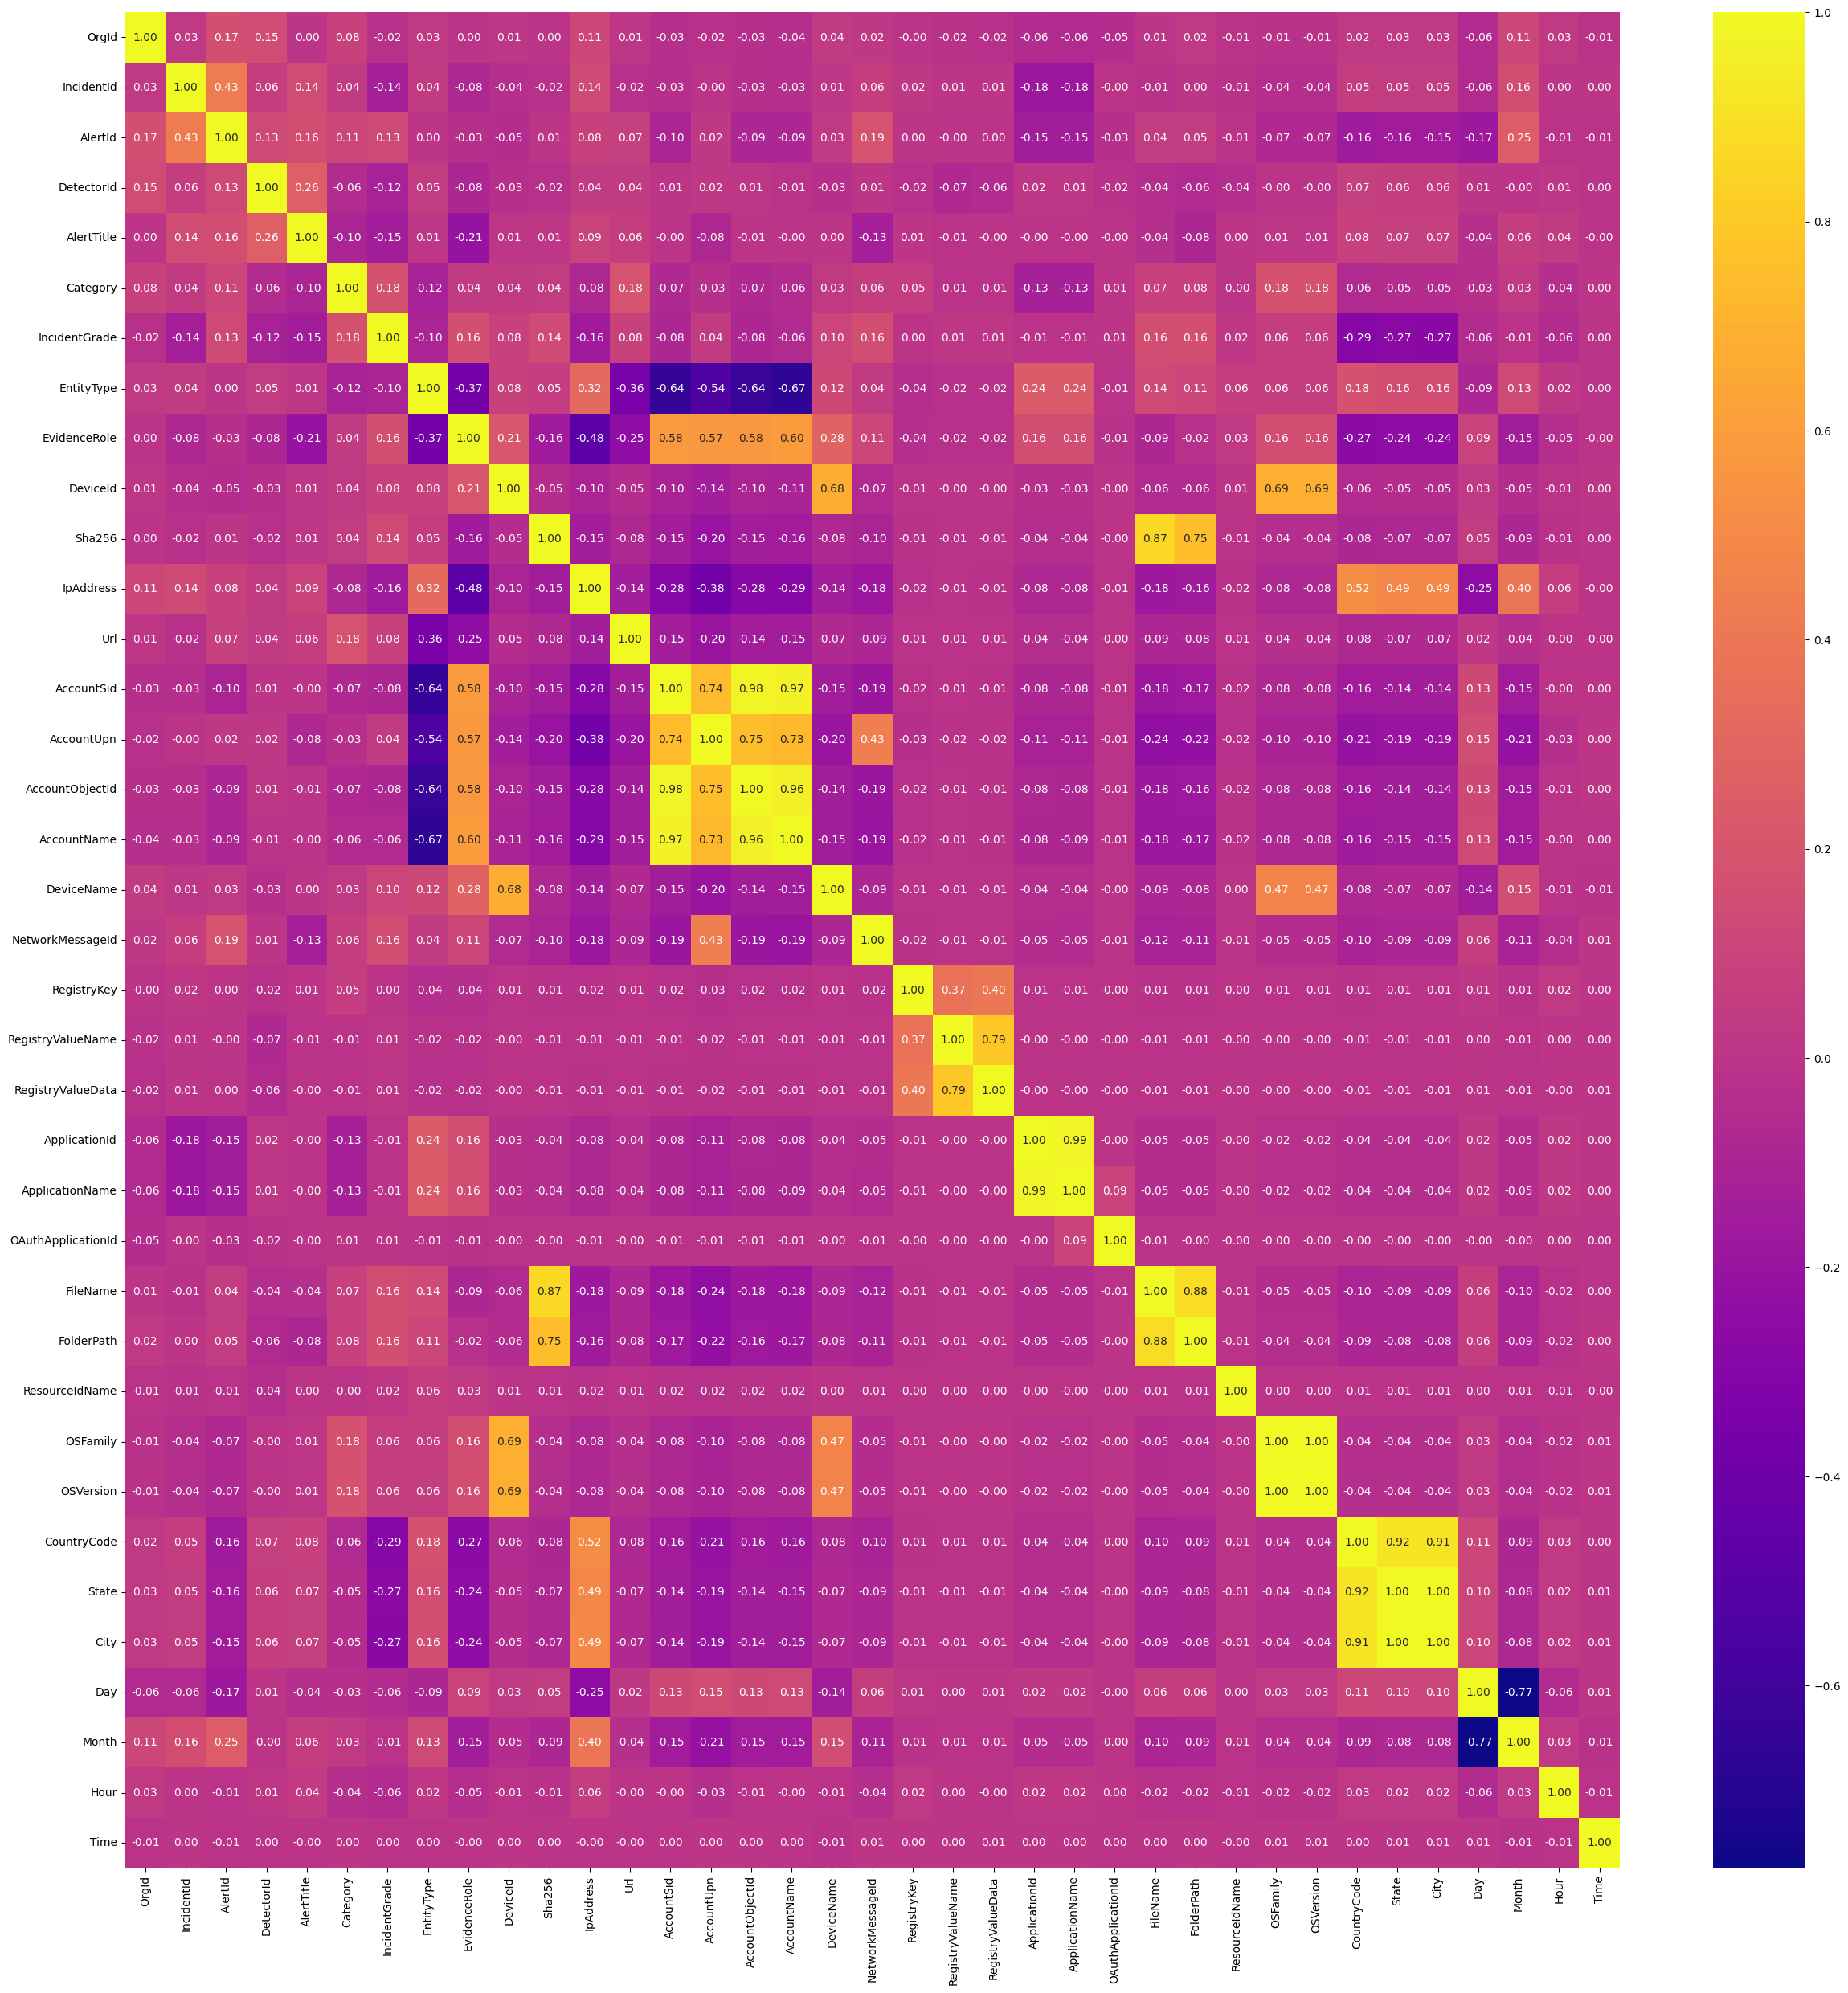

In [26]:
plt.figure(figsize=(30,30))
sns.heatmap(data=df.corr(),cmap='plasma',annot=True,fmt='.2f')
plt.show()

In [27]:
df=df.drop(columns=['AccountSid','AccountUpn','AccountObjectId','AccountName','RegistryValueName','RegistryValueData','ApplicationId','ApplicationName','FileName','FolderPath','OSFamily','OSVersion','CountryCode','Sha256','State','City','Hour','Time'],axis=1)

In [28]:
df.columns

Index(['OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'IpAddress', 'Url', 'DeviceName', 'NetworkMessageId', 'RegistryKey',
       'OAuthApplicationId', 'ResourceIdName', 'Day', 'Month'],
      dtype='object')

## Data splitting

In [29]:
x=df.drop('IncidentGrade',axis=1).values
y=df['IncidentGrade']

### SMOTE

In [30]:
df['IncidentGrade'].value_counts()

IncidentGrade
0    43549
2    34887
1    21564
Name: count, dtype: int64

In [31]:

import imblearn
from imblearn.over_sampling import RandomOverSampler
rs=RandomOverSampler(random_state=0)
x_res,y_res=rs.fit_resample(x,y)


In [32]:
y_res.value_counts()

IncidentGrade
2    43549
1    43549
0    43549
Name: count, dtype: int64

In [33]:
x_train,x_test,y_train,y_test=train_test_split(x_res,y_res,random_state=0,test_size=0.2,stratify=y_res)

## Models

In [34]:
models={'LogisticRegression':LogisticRegression(),
        'DecisionTreeClassifier':DecisionTreeClassifier(),
        'RandomForestClassifier':RandomForestClassifier(),
        'GradientBoostingClassifier':GradientBoostingClassifier()}

In [35]:
x_test

array([[     18,  232346, 1376746, ...,    3586,       6,       6],
       [    713,   41592,  565603, ...,    3586,       6,       6],
       [      8,    7513,  618734, ...,    3586,      10,       6],
       ...,
       [   1230,   99962, 1075910, ...,    3586,      11,       6],
       [     73,   93307,   83823, ...,    3586,      15,       6],
       [      7,     428,    1024, ...,    3586,       2,       6]])

In [36]:
result=[]
for name,model in models.items():
    model=model
    model.fit(x_train,y_train)
    y_prediction=model.predict(x_test)
    accuracy=accuracy_score(y_test,y_prediction)
    recall=recall_score(y_test,y_prediction,average='macro')
    precision=precision_score(y_test,y_prediction,average='macro')
    f1_scr= f1_score(y_test,y_prediction,average='macro')
    result.append({'Model' : name, 'Accuracy' : accuracy*100, 'Recall' : recall*100, 'Precision' : precision*100 , 'f1_score' : f1_scr*100})


C:\Users\ukesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
pd.DataFrame(result)

,Model,Accuracy,Recall,Precision,f1_score
0,LogisticRegression,50.367394,50.367394,51.161254,48.827556
1,DecisionTreeClassifier,94.626866,94.626866,94.642163,94.617770
2,RandomForestClassifier,94.496747,94.496747,94.517259,94.494371
3,GradientBoostingClassifier,79.969384,79.969384,81.030066,80.062754


## Hyperparameteric tunning

## Decision tree

In [38]:
dec_tree_param={
    'ccp_alpha':[0.00001,0.0001,0.001,0.01,0.1,1],
    'criterion':['gini','entropy','log_loss'],
    'max_depth':[50,60,70,80,90,100],
    'max_leaf_nodes':[1500,1800,2000,2200]
}

In [39]:
dec_tree_tunning=RandomizedSearchCV(estimator=DecisionTreeClassifier(),param_distributions=dec_tree_param,cv=5,random_state=1)
dec_tree_tunning.fit(x_train,y_train)
dec_tree_tun_pre=dec_tree_tunning.predict(x_test)
acc_dec_tree=accuracy_score(y_test,dec_tree_tun_pre)
recall_dec_tree=recall_score(y_test,dec_tree_tun_pre,average='macro')
pre_dec_tree=precision_score(y_test,dec_tree_tun_pre,average='macro')
f1_dec_tree=f1_score(y_test,dec_tree_tun_pre,average='macro')

C:\Users\ukesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


#### DecisionTree Scores after Hyperparameteric tunning

In [40]:
pd.DataFrame({'Model' : 'DecisionTreeClassifier', 'Accuracy' : acc_dec_tree*100, 'Recall' : recall_dec_tree*100, 'Precision' : pre_dec_tree*100 , 'f1_score' : f1_dec_tree*100},index=[0])

,Model,Accuracy,Recall,Precision,f1_score
0,DecisionTreeClassifier,91.982396,91.982396,92.013767,91.97839


#### Best parameters

In [41]:
pd.DataFrame(dec_tree_tunning.best_params_,index=[0])

,max_leaf_nodes,max_depth,criterion,ccp_alpha
0,2200,100,entropy,0.0001


## Random forest

In [42]:
ran_param={
    'ccp_alpha':[0.0001,0.001,0.01,0.1,1],
    'n_estimators':[30,50,70,90,110,140,160,180],
    'criterion':['gini','log_loss','entropy'],
    'min_samples_leaf':[5,10,15,20,25,30,35,40],
    'max_depth':[50,60,70,80,90,100,110],
    'max_leaf_nodes':[1000,1500,2000,2500,3000]
}

In [43]:
ran_tunning=RandomizedSearchCV(estimator=RandomForestClassifier(),param_distributions=ran_param,cv=5,random_state=0)
ran_tunning.fit(x_train,y_train)
ran_tun_pre=ran_tunning.predict(x_test)
accu_ran_score=accuracy_score(y_test,ran_tun_pre)
pre_ran_score=precision_score(y_test,ran_tun_pre,average='macro')
recall_ran_scr=recall_score(y_test,ran_tun_pre,average='macro')
f1_ran_scr=f1_score(y_test,ran_tun_pre,average='macro')

#### RandomForest Scores after hyperparameter tunning

In [44]:
pd.DataFrame({'Model' : 'RandomForestClassifier', 'Accuracy' : accu_ran_score*100 , 'Recall' : recall_ran_scr*100 , 'Precision' : pre_ran_score*100 , 'f1_score' : f1_ran_scr*100},index=[0])

,Model,Accuracy,Recall,Precision,f1_score
0,RandomForestClassifier,86.636051,86.636051,87.162635,86.688481


#### Best parameters

In [45]:
pd.DataFrame(ran_tunning.best_params_,index=[0])

,n_estimators,min_samples_leaf,max_leaf_nodes,max_depth,criterion,ccp_alpha
0,110,30,2000,60,log_loss,0.0001


## XGBOOST

In [46]:
xgb=xgboost.XGBClassifier()
xgb.fit(x_train,y_train)
xgb_score=xgb.score(x_test,y_test)
print('Score : ',xgb_score*100)

Score :  90.7998469192499


In [47]:
xgb_para={
    'n_estimators':[110,140,150,180,200],
    'learning_rate':[0.001,0.01,0.1,1],
    'max_depth':[5,8,10,12,15,18,20]
}

In [48]:
xgb_tunning=RandomizedSearchCV(estimator=xgboost.XGBClassifier(),param_distributions=xgb_para,cv=5)
xgb_tunning.fit(x_train,y_train)
xgb_pre=xgb_tunning.predict(x_test)
acc_xgboost=accuracy_score(y_test,xgb_pre)
pre_xgboost=precision_score(y_test,xgb_pre,average='macro')
recall_xgboost=recall_score(y_test,xgb_pre,average='macro')
f1_xgboost=f1_score(y_test,xgb_pre,average='macro')


#### XGBClassifier Score after hyperparameteric tunning

In [49]:
pd.DataFrame({'Model' : 'XGBClassifier', 'Accuracy' : acc_xgboost*100, 'Recall' : recall_xgboost*100, 'Precision' : pre_xgboost*100 , 'f1_score' : f1_xgboost*100},index=[0])

,Model,Accuracy,Recall,Precision,f1_score
0,XGBClassifier,95.216227,95.216227,95.229386,95.212431


#### Best parameters

In [50]:
pd.DataFrame(xgb_tunning.best_params_,index=[0])

,n_estimators,max_depth,learning_rate
0,110,18,0.1
